# Course 1: Classification and Vector Spaces
# Week 1: Logistic Regression for Sentiment Analysis of Tweets
## Own project: Analyzing the sentiment of my own tweets

## Download my own tweets

In [1]:
%%capture
%run assignment.ipynb

In [2]:
import tweepy
import json

In [3]:
# Load Twitter credentials
api_keys = json.load(open('twitter-api-keys.local.json'))
bearer_token = api_keys["bearer_token"]
client = tweepy.Client(
    bearer_token=api_keys['bearer_token'], wait_on_rate_limit=True)

auth = tweepy.OAuthHandler(
    consumer_key=api_keys['api_key'],
    consumer_secret=api_keys['api_key_secret'],
    access_token=api_keys['access_token'],
    access_token_secret=api_keys['access_token_secret'])
api = tweepy.API(auth, wait_on_rate_limit=True)

In [4]:
me = "fcx_xm"
tweets = api.user_timeline(screen_name=me, count=1000)
tweet_text = [tweet.text for tweet in tweets]

## Creating preprocessing functions for Spanish tweets

In [5]:
import unidecode
import nltk
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
stemmer = SnowballStemmer("spanish")

nltk.download('punkt')

True

In [6]:
# String cleaning function
def clean_string(string):
    """
    Input:
        - string: a string to be cleaned
    Output:
        - cleaned_string: a clean string with the following actions:
            - lowercase
            - remove punctuation
            - remove URLs, hashtags, mentions
    """
    string = re.sub(r'http\S+', '', string)
    string = re.sub(r'RT', '', string)
    string = re.sub(r'@\S+', '', string)
    string = re.sub(r'#', '', string)
    string = re.sub(r'[^\w\s]', '', string)
    string = string.lower()
    string = unidecode.unidecode(string)

    return string

In [7]:
# Tokenize function
def tokenize(string):
    """
    Input:
        - string: a string to be tokenized
    Output:
        - tokens: a list of tokens
    """
    tokens = word_tokenize(string)

    return tokens

In [8]:
# Remove spanish stopwords function
def remove_stopwords(tokens):
    """
    Input:
        - tokens: a list of tokens
    Output:
        - tokens: a list of tokens without stopwords
    """
    stopwords = nltk.corpus.stopwords.words('spanish')
    tokens = [token for token in tokens if token not in stopwords]

    return tokens

In [9]:
# Stem function for spanish
def stem(tokens):
    """
    Input:
        - tokens: a list of tokens
    Output:
        - tokens: a list of stems
    """
    stems = [stemmer.stem(token) for token in tokens]

    return stems

In [10]:
# Show transformation progress
print('Original text:')
print(tweet_text[0])
print('Cleaned text:')
print(clean_string(tweet_text[0]))
print('Tokenized text:')
print(tokenize(clean_string(tweet_text[0])))
print('Removed stopwords:')
print(remove_stopwords(tokenize(clean_string(tweet_text[0]))))
print('Stemmed text:')
print(stem(remove_stopwords(tokenize(clean_string(tweet_text[0])))))

Original text:
RT @nocontextfooty: https://t.co/OIbP4I2vrq
Cleaned text:
  
Tokenized text:
[]
Removed stopwords:
[]
Stemmed text:
[]


In [11]:
# Entire process of the string
def process_text(tweet):
    """
    Input:
        - tweet: a string to be processed
    Output:
        - tokens: a list of tokens
    """
    tweet = clean_string(tweet)
    tokens = tokenize(tweet)
    tokens = remove_stopwords(tokens)
    tokens = stem(tokens)

    return tokens

In [12]:
# Processed tweets
processed_tweets = [process_text(tweet) for tweet in tweet_text]
print(processed_tweets[:5])

[[], ['penit', 'pon', 'oakleys', 'antigu', 'gt60e', 'on', 'god'], ['fr'], ['obsess', 'with', 'whoev', 'saw', 'gum', 'on', 'sidewalk', 'and', 'was', 'lik', 'let', 'add', 'this', 'to', 'the', 'poisson', 'distribution', 'wikipedi', 'articl'], []]


## Getting data for spanish positivity and negativity

I will be using a dataset of positive and negative texts.

URL: https://www.kaggle.com/datasets/luisdiegofv97/imdb-dataset-of-50k-movie-reviews-spanish?select=IMDB+Dataset+SPANISH.csv

In [13]:
import pandas

In [14]:
# Load the imdb_dataset.csv
# Keep columns review_es, sentimiento. In sentimiento, replace "positivo" with 1 and "negativo" with 0
# data = pandas.read_csv('imdb_dataset.csv')
# data = data[['review_es', 'sentimiento']]
# data.sentimiento = data.sentimiento.replace(['positivo', 'negativo'], [1, 0])

# Once the dataset has been cleaned
data = pandas.read_csv('imdb_dataset_processed.csv')


In [15]:
# Save data in a new csv file
# data.to_csv('imdb_dataset_processed.csv', index=False)

In [16]:
# Create x and y lists
x = data.review_es
y = data.sentimiento

# Print head 5 and len of both
print(data.head(5))
print(len(x))
print(len(y))


                                           review_es  sentimiento
0  Uno de los otros críticos ha mencionado que de...            1
1  Una pequeña pequeña producción.La técnica de f...            1
2  Pensé que esta era una manera maravillosa de p...            1
3  Básicamente, hay una familia donde un niño peq...            0
4  El "amor en el tiempo" de Petter Mattei es una...            1
50000
50000


In [17]:
# Create frequency distribution of the words in the reviews

def build_freqs(train_x, train_y):
    """
    Input:
        - train_x: the list of reviews
        - train_y: the list of labels
    Output:
        - freqs: a dictionary with the frequency of each word in the reviews

    Dictionary structure:
    {
        'word1': {
            'positive': int,
            'negative': int
    }
    """

    freqs = {}
    for i in tqdm(range(len(train_x))):
        tokens = process_text(train_x[i])
        label = train_y[i]

        for token in tokens:
            if token not in freqs:
                freqs[token] = {'positive': 0, 'negative': 0}
            if label == 1:
                freqs[token]['positive'] += 1
            else:
                freqs[token]['negative'] += 1


    return freqs

In [18]:
# Freq dict creation takes around 10 minutes. Save it to a file and load it later if it exists
import os
if os.path.exists('freqs.json'):
    freqs = json.load(open('freqs.json'))
else:
    freqs = build_freqs(x, y)
    json.dump(freqs, open('freqs.json', 'w'))

In [19]:
# Show sorted list of words and their frequencies
print(sorted(freqs.items(), key=lambda x: x[1]['positive'] + x[1]['negative'], reverse=True)[:10])
print(type(freqs))
print(len(freqs))

[('pelicul', {'positive': 82967, 'negative': 90708}), ('mas', {'positive': 30251, 'negative': 27598}), ('the', {'positive': 29416, 'negative': 24283}), ('si', {'positive': 17832, 'negative': 22850}), ('hac', {'positive': 18234, 'negative': 19785}), ('pued', {'positive': 17054, 'negative': 18046}), ('sol', {'positive': 14071, 'negative': 17358}), ('buen', {'positive': 15215, 'negative': 15671}), ('ser', {'positive': 13122, 'negative': 15108}), ('histori', {'positive': 15469, 'negative': 12110})]
<class 'dict'>
218950


### Train and test data

In [20]:
# Create train and test datasets
train_x = x[:int(len(x) * 0.8)]
train_y = y[:int(len(y) * 0.8)]
test_x = x[int(len(x) * 0.8):]
test_y = y[int(len(y) * 0.8):]

# Print len of all
print(len(train_x))
print(len(train_y))
print(len(test_x))
print(len(test_y))

40000
40000
10000
10000


### Sigmoid, gradient descent, feature extraction, and logistic regression

In [21]:
# Sigmoid function
def sigmoid(x):
    """
    Input:
        - x: a number
    Output:
        - sigmoid: the sigmoid of x
    """
    sigmoid = 1 / (1 + np.exp(-x))

    return sigmoid

In [22]:
def gradient_descent(x, y, theta, alpha, num_iters):
    '''
    Input:
        x: matrix of features which is (m,n+1)
        y: corresponding labels of the input matrix x, dimensions (m,1)
        theta: weight vector of dimension (n+1,1)
        alpha: learning rate
        num_iters: number of iterations you want to train your model for
    Output:
        J: the final cost
        theta: your final weight vector
    Hint: you might want to print the cost to make sure that it is going down.
    '''
    # get 'm', the number of rows in matrix x

    J_history = []

    m = x.shape[0]
    
    for i in tqdm(range(0, num_iters)):
        
        # get z, the dot product of x and theta
        z = np.dot(x,theta)
        
        # get the sigmoid of z
        h = sigmoid(z)
        
        # calculate the cost function
        J = -1./m * (np.dot(y.transpose(), np.log(h)) + np.dot((1-y).transpose(),np.log(1-h)))    

        # update the weights theta
        theta = theta - (alpha/m) * np.dot(x.transpose(),(h-y))

        # append the cost to the list
        J_history.append(J)

    # Flatten the list of costs into a 1D array
    J_history = np.array(J_history).flatten()

    return J_history, theta

In [34]:
import cupy as cp
# gradient descent function using cupy 
def gradient_descent_cupy(x, y, theta, alpha, num_iters):
    '''
    Input:
        x: matrix of features which is (m,n+1)
        y: corresponding labels of the input matrix x, dimensions (m,1)
        theta: weight vector of dimension (n+1,1)
        alpha: learning rate
        num_iters: number of iterations you want to train your model for
    Output:
        J: the final cost
        theta: your final weight vector
    Hint: you might want to print the cost to make sure that it is going down.
    '''
    # get 'm', the number of rows in matrix x

    J_history = []

    m = x.shape[0]
    
    for i in tqdm(range(0, num_iters)):
        
        # get z, the dot product of x and theta
        z = cp.dot(x,theta)
        
        # get the sigmoid of z
        h = sigmoid(z)
        
        # calculate the cost function
        y_cupy = cp.array(y)
        h_cupy = cp.array(h)
        J = -1./m * (cp.dot(y_cupy.transpose(), cp.log(h_cupy)) + cp.dot((1-y_cupy).transpose(),cp.log(1-h_cupy)))

        # update the weights theta
        theta = theta - (alpha/m) * cp.dot(x.transpose(),(h-y))

        # append the cost to the list
        J_history.append(J)

    # Flatten the list using cupy
    # Implicit conversion to a NumPy array is not allowed. Please use `.get()` to construct a NumPy array explicitly.
    J_history = cp.array(J_history).get().flatten()
    
    return J_history, theta

In [24]:
# Feature extraction function
def feature_extraction(text, freqs):
    """
    Input:
        - word: a text
        - freqs: a dictionary with the frequency of each word in the reviews
    Output:
        - features: an array of (1, 3) with the following features:
            - 1 = 1
            - 2 = frequency of the tokens in the positive reviews
            - 3 = frequency of the tokens in the negative reviews
    """
    features = np.zeros((1, 3))
    features[0, 0] = 1
    tokens = process_text(text)
    for token in tokens:
        features[0][1] += freqs[token]['positive']
        features[0][2] += freqs[token]['negative']

    assert(features.shape == (1, 3))
    return features

In [25]:
# Test feature extraction with 5 random reviews
print('Feature extraction with 5 random reviews:')
idx = np.random.randint(0, len(x), 2)
for i in idx:
    print("Review:", x[i])
    print("Features:", feature_extraction(x[i], freqs))

Feature extraction with 5 random reviews:
Review: Este es un esfuerzo decente, pero el tipo que escribió el guión parece estar un poco en la oscuridad en cuanto a lo que hace que una película de zombies sea fresca.No, no son errores de CGI y compañías de software.En realidad, no estoy seguro de si era una compañía de software, lo vi sin subtítulos, así que tuve que adivinar de qué están hablando.De todos modos, mi punto era, en lugar de desperdiciar tu tiempo animando algún error tonto, por qué no lanzar más zombies y más acción.2/3 de los 20 minutos consisten en boletines de noticias, insectos, algunos chicos que gritan sobre algo.Y para empeorar las cosas (más aburridas), la mayoría de las muertes ocurren fuera de la pantalla.Me doy cuenta de que todo es demasiado común para las películas sin presupuesto, pero luego hubo algunos efectos muy impresionantes (bueno, tipo-a de) que me dejó preguntarme por qué el director (o guionista, lo que sea) eligió centrarse en cómo comenzó la epide

In [26]:
# Example using invented words that should not appear in the reviews (to test the feature extraction)
print(extract_feature("pium piam", freqs))

[[1. 0. 0.]]


0.5
0.7310585786300049


  0%|          | 0/1000 [00:00<?, ?it/s]

Cost: 0.49280449604074006
Theta: [[-1.20844485]
 [ 0.21337896]
 [ 0.06880041]]


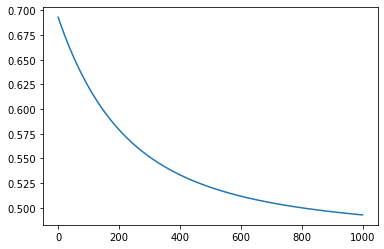

In [35]:
# Test sigmoid and gradient
print(sigmoid(0))
print(sigmoid(1))

tmp_x = np.append(np.ones((10, 1)), np.random.randn(10, 2), axis=1)
tmp_x
tmp_y = (np.random.randn(10, 1) > 0.35).astype(float)
tmp_y

tmp_J, tmp_theta = gradient_descent_cupy(tmp_x, tmp_y, np.zeros((3, 1)), 0.01, 1000)
print("Cost:", tmp_J[-1]) 
print("Theta:", tmp_theta)

# Plot the cost function
plt.plot(tmp_J)

In [36]:
# Extract the features from the training set
X = np.zeros((len(train_x), 3))
for i in tqdm(range(len(train_x))):
    X[i, :] = feature_extraction(train_x[i], freqs)


  0%|          | 0/40000 [00:00<?, ?it/s]

In [37]:
# Y is array of dim (1, len(train_y)), filled with train_y. Flatten it into a 1D array
Y = np.array(train_y).flatten()

In [38]:
J, theta = gradient_descent_cupy(X, Y, np.zeros((3, 1)), 1e-3, 1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
# Print cost and theta
print("Training cost:", J[-1])
print("Final weight vectors:", theta)